# Instructions
Please run the following cells sequentially
1. (Optional) Running 1b adds semantic labels and requires addtional resources (default to a second GPU).
* The function relies on an additonal image captioning model, e.g., BLIP.  
* The labels are nouns, extracted from the generated caption. 
* It merge masks sharing the same label. 
2. Add your own image and update ``image_path`` variable. 
3. Feel free to play with DiffSeg hyper-parameters such as the ``KL_THRESHOLD``.

# Import

In [1]:
import tensorflow as tf
from keras_cv.src.models.stable_diffusion.image_encoder import ImageEncoder
from diffusion_models.stable_diffusion import StableDiffusion
from utils import process_image, augmenter, vis_without_label
from diffseg.segmentor import DiffSeg

# !nvidia-smi # Uncomment if you have an NVIDIA GPU

Using TensorFlow backend


2023-11-23 12:18:24.217860: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-11-23 12:18:24.217880: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-11-23 12:18:24.217883: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-11-23 12:18:24.217908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-23 12:18:24.217923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
print(f"GPUs available: ", tf.config.experimental.list_physical_devices('GPU'))
device = tf.test.gpu_device_name()
print(tf.test.gpu_device_name())

GPUs available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


2023-11-23 12:18:24.624704: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-23 12:18:24.624721: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-23 12:18:24.624839: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-23 12:18:24.624845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 1. Initialize SD Model

In [3]:
# Inialize Stable Diffusion Model on GPU:0 
with tf.device('/GPU:0'):
  image_encoder = ImageEncoder()
  vae=tf.keras.Model(
            image_encoder.input,
            image_encoder.layers[-1].output,
        )
  model = StableDiffusion(img_width=512, img_height=512)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


# 2. Run Inference on Real Images

In [4]:
# The first time running this cell will be slow because the model needs to download and loads pre-trained weights.

image_path = "./images/img1.jpeg" # Specify the path to your image

with tf.device('/GPU:0'):
  images = process_image(image_path)
  images = augmenter(images)
  latent = vae(tf.expand_dims(images, axis=0), training=False)
  images, weight_64, weight_32, weight_16, weight_8, _, _, _, _ = model.text_to_image(
    prompt=None,
    batch_size=1,
    latent=latent,
    timestep=300
  )

2023-11-23 12:18:28.646358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


# 3. Generate Segementation Masks

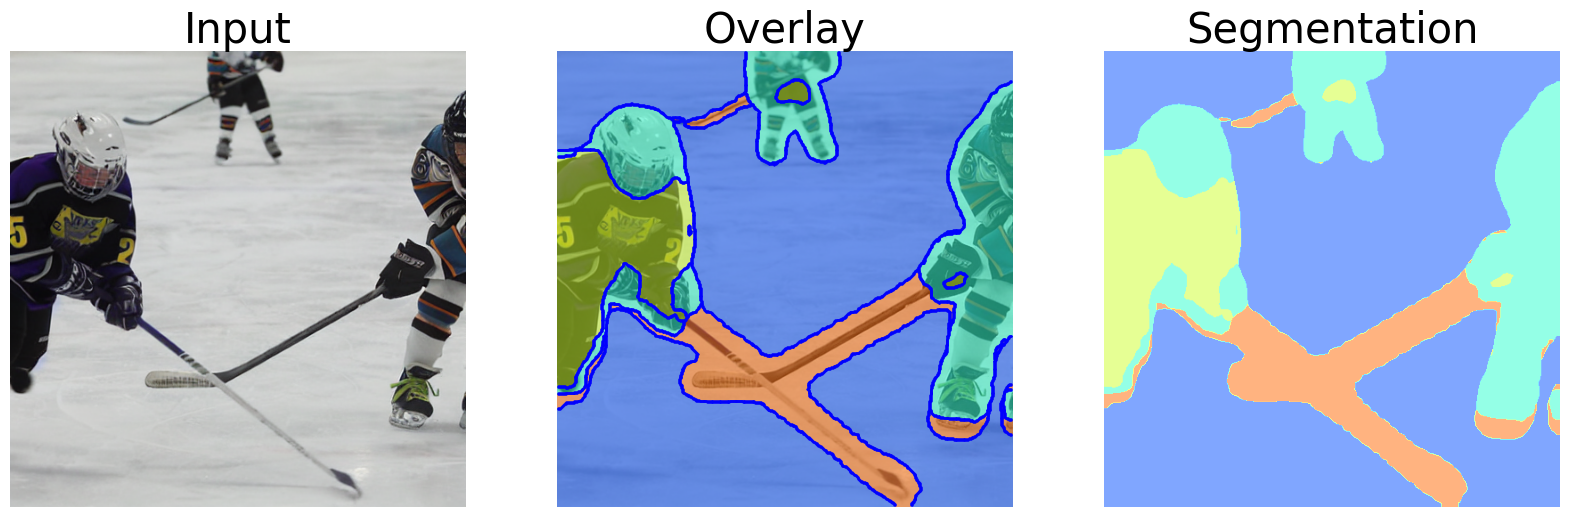

In [11]:
KL_THRESHOLD = [0.9]*3 # KL_THRESHOLD controls the merging threshold
NUM_POINTS = 16
REFINEMENT = True


with tf.device('/GPU:0'):
  segmentor = DiffSeg(KL_THRESHOLD, REFINEMENT, NUM_POINTS)
  pred = segmentor.segment(weight_64, weight_32, weight_16, weight_8) # b x 512 x 512

  for i in range(len(images)):
    vis_without_label(pred[i], images[i], num_class=len(set(pred[i].flatten())))

In [12]:
weight_64.shape

(1, 8, 4096, 4096)